# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

# Solutions by Jonas Cuadrado

July 17, 2018

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

We should start with some exploratory data analysis, preferably graphical. How large is the sample? Are we reading the information correctly?

In [2]:
print("Head of the dataframe")
print(df.head())

print("Dataframe statistics")
print(df.describe())

Head of the dataframe
   temperature gender  heart_rate
0         99.3      F        68.0
1         98.4      F        81.0
2         97.8      M        73.0
3         99.2      F        66.0
4         98.0      F        73.0
Dataframe statistics
       temperature  heart_rate
count   130.000000  130.000000
mean     98.249231   73.761538
std       0.733183    7.062077
min      96.300000   57.000000
25%      97.800000   69.000000
50%      98.300000   74.000000
75%      98.700000   79.000000
max     100.800000   89.000000


It seems the import went well, the dataset is rather small, only has 130 rows. It doesn't seems as a representative  sample of the 7 billion people in the world, but we should work with what we have.

### 1. Normality

To assess if we have a normal distribution of temperatures we will plot the empirical cumulative distribution function, and we will use both the D’Agostino and Pearson’s and the Shapiro-Wilk tests.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# start plotting a histogram with the normal pdf on top
# histogram
plt.hist(df.temperature, bins=20, normed=True)
# normal
x = np.linspace(np.floor(min(df.temperature)), np.floor(max(df.temperature))+1, 100)
plt.plot(x,mlab.normpdf(x, np.mean(df.temperature), np.sqrt(np.var(df.temperature))))
# complete the graph
plt.xlabel("Temperature [ºF]")
plt.ylabel("pdf")
plt.show()



By eye it doesn't look very normal, but the tails ar not too heavy, so it could be normal. LEt's look at the ECDF

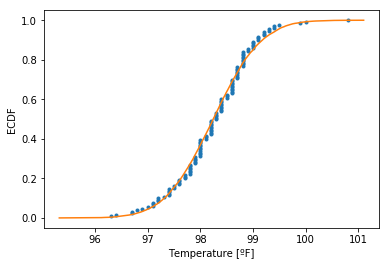

In [4]:
# make the cumulative distribution function and plot it along with the normal one

# I can use a function described in datacamp to simplify the process...
def ecdf(data):
    """1D empirical cumulative prob distr fun"""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

# MAIN
xecdf, yecdf = ecdf(df.temperature)
theordataset = np.random.normal(np.mean(df.temperature), np.sqrt(np.var(df.temperature)),25000)
xth, yth = ecdf(theordataset)
# plot
plt.plot(xecdf, yecdf, '.')
plt.plot(xth, yth)
plt.xlabel('Temperature [ºF]')
plt.ylabel('ECDF')
#plt.legend(['Empirical data','Theoretical CDF for a normal with max-likelihood parameters'])
plt.show()

It actually looks much more normal than before! Let's perform the two aforementioned tests... 

In [5]:
from scipy import stats

print('p-value for Shapiro-Wilk normality test (large p => normally distributed)')
print(stats.shapiro(df.temperature)[1])

print('\n')
print('p-value for D’Agostino and Pearson’s normality test (large p => normally distributed)')
print(stats.normaltest(df.temperature).pvalue)

p-value for Shapiro-Wilk normality test (large p => normally distributed)
0.233174666762352


p-value for D’Agostino and Pearson’s normality test (large p => normally distributed)
0.2587479863488254


According to both tests, there is not enough evidence to discard the null hypothesis: the sample could be normal. We observe a p-value close to 25% in each case.

### 2. Size and independence

We have seen already that we have 130 samples. This is large enough for the CLT, as usually 30 measures are essentially normal, but it is NOT a large sample if we aim to estimate the body temperature with a 95% cnfidence interval of +/- 0.1 ºF. Indeed, we can estimate the sample size n assuming a normal distribution as follows

In [6]:
# width of confidence interval
W = 0.1
# std of distribution
sigma=np.std(df.temperature)
# sample size
n = (4*sigma/W)**2
print(n)

853.4759763313598


We need over 850 samples. But we can have a 0.3 ºF interval with the current data.

To look at the independence, we don't have much additional information to test that. If the heart rate is independent of the temperature we shouldn't see a trend between the two variables, but that assumption cannot be made. What we can see if there are two identical points, or poits that follow a path: that could indicate non-independence

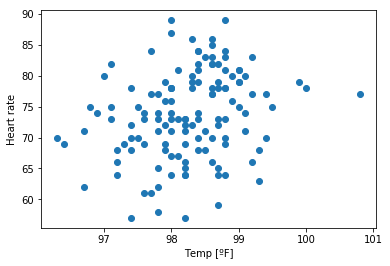

In [7]:
# plot both datasets

plt.scatter(df.temperature, df.heart_rate)
plt.xlabel('Temp [ºF]')
plt.ylabel('Heart rate')
plt.show()

In [8]:
# are there any duplicates?
print(df[df.duplicated()])

     temperature gender  heart_rate
75          98.8      M        78.0
87          98.0      M        78.0
127         98.2      F        73.0


Here, conclude somethign about the independence...
We don't know if the samples are from different people, or the same person is taken several time at different times. They are probably not fully independent as there are repeated rows. But not many. We need more info.

We will take it as independent regardless! Otherwise there's not much we can do

### 3. What's the real mean?

First, we can look at the mean of the data. Then, we should bootstrap to see if it is sensible.

Sample mean
98.24923076923078
95% confidence interval
[98.12076923 98.37307692]
99% confidence interval
[98.08153077 98.41154231]


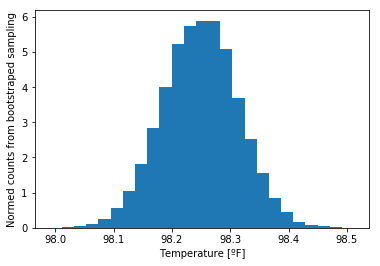

In [9]:
print('Sample mean')
print(np.mean(df.temperature))

# bootstrapping
numbs = 10000
means = np.empty(numbs)
for i in range(numbs):
    bssample = np.random.choice(df.temperature, df.temperature.size)
    means[i] = np.mean(bssample)
print('95% confidence interval')
print(np.percentile(means,[2.5, 97.5]))
print('99% confidence interval')
print(np.percentile(means,[0.5, 99.5]))

plt.hist(means,bins=25,normed=True)
plt.xlabel('Temperature [ºF]')
plt.ylabel('Normed counts from bootstraped sampling')
plt.show()

It is very clear that the temperature is NOT 98.6 ºF, as it is very far from the sampled data. In fact, the there is less than 1 in 10000 cases in which we could obtain such a mean temperature from the data, which means that the p-value for the hypothesis "The mean of the sample could be 98.6 ºF" is less than 0.01%. Therefore, there is enough evidence to discard that hypothesis

To determine this using proper statistics we should use a 1-sample test. There is only one dataset, and we are comparing it to an aggregate statistic from a theoretical prediction. Moreover, we do not have an expectation for what the variance of the real distribution should be, so we need to use a one-sample t-test statistic

In [10]:
# one-sample t-test

mu0 = 98.6
mus = np.mean(df.temperature)
div = np.std(df.temperature)/np.sqrt(df.temperature.size)
print ('t statistic =', (mus - mu0)/div)

print('Degrees of freedom:', df.temperature.size-1)

# p-value...
print('p-value =', 2*stats.t.pdf((mus - mu0)/div, df.temperature.size-1))

t statistic = -5.475925202078116
Degrees of freedom: 129
p-value = 1.0026408051946806e-06


So indeed there is a lot of strength in saying that the mean body temperature is NOT 98.6 ºF
If we tried the z-test, we would obtain a very similar value because of two reasons: first, we would need to assume the real standard deviation to be the empirical one, and second, a Student's distribution with over 100 degrees of freedom is very similar to a normal. So...

In [11]:
# one-sample z-test

print ('z statistic =', (mus - mu0)/div)
# p-value...
print('p-value =', 2*stats.norm.pdf((mus - mu0)/div))

z statistic = -5.475925202078116
p-value = 2.4581914310682793e-07


### 4. Small sample

For a sample of size 10 there would be a greater difference between the p-values: a small sample has a higher probability of finding an extreme vale, as the tails of a Student's t are heavier for low dof. LEt's look at how both change

In [12]:
#subsample
np.random.seed(42)
subsample = np.random.choice(df.temperature, replace=False, size=10)

# one-sample t-test
mu0 = 98.6
mus = np.mean(subsample)
div = np.std(subsample)/np.sqrt(10)
print ('t statistic =', (mus - mu0)/div)
print('Degrees of freedom:', 9)

# p-value...
print('p-value =', 2*stats.t.pdf((mus - mu0)/div, 9))

# one-sample z-test
print ('z statistic =', (mus - mu0)/div)
# p-value...
print('p-value =', 2*stats.norm.pdf((mus - mu0)/div))

t statistic = -1.6450370593201415
Degrees of freedom: 9
p-value = 0.20846996190316056
z statistic = -1.6450370593201415
p-value = 0.2062090506230799


AS we observe, there is a higher probability that the actual temperature is 98.6 ºF. This evidences the importance of large enough datasets. In addition, the difference between the t and z statistics has increased, as the Student's t distirbution is now much further from the normal than before 

### 5. Abonormal temperature

I will use the 3-sigma principle: if a measurement is  outside the 99.9% of the distribution, it is abnormal. Ww have the bootstrapped interval available already, we need to find as well the statistic approach.

In [13]:
# from bootstrapped
print('Bootstrapped 99.9% confidence interval')
print(np.percentile(means,[0.05, 99.95]))

# from t statistic
mus = np.mean(df.temperature)
div = np.std(df.temperature)/np.sqrt(df.temperature.size)
print('t-statistic 99.9% confidence interval')
print([mus-3*div,mus+3*div])

Bootstrapped 99.9% confidence interval
[98.03538462 98.46000308]
t-statistic 99.9% confidence interval
[98.0570609251452, 98.44140061331636]


Therefore, anything below 98.05 ºF and above 98.45 ºF can be considered abnormal.

### 6. Differences between M and F

Let's look at the two datasets. Here, we need two-sample tests to determine if they are different or not. After some preliminary plots, we will try bootstrapping, then we will perform actual statistics

   temperature gender  heart_rate
0         99.3      F        68.0
1         98.4      F        81.0
3         99.2      F        66.0
4         98.0      F        73.0
8         98.4      F        84.0
    temperature gender  heart_rate
2          97.8      M        73.0
5          99.2      M        83.0
6          98.0      M        71.0
7          98.8      M        78.0
12         98.2      M        72.0


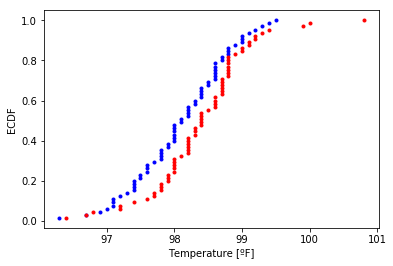

In [14]:
tempf = df[df.gender=='F']
print(tempf.head())
tempm = df[df.gender=='M']
print(tempm.head())

# ECDF of the two (we are not testing normality, but if they are the same)
xm, ym = ecdf(tempm.temperature)
xf, yf = ecdf(tempf.temperature)
plt.plot(xm,ym, '.',color='blue')
plt.plot(xf,yf, '.',color='red')
plt.xlabel('Temperature [ºF]')
plt.ylabel('ECDF')
plt.show()

The ECDF seems to indicate that the means are different, with the male lower than the female, and so are the tails, but it's not definitive. Let's look at it in detail with bootstrapping

Empirical difference of T =  -0.289230769230727
p-value = 0.0105


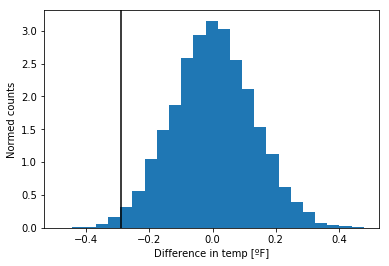

In [15]:
# empirical difference in mean:
diff_fm_means = np.mean(tempm.temperature)-np.mean(tempf.temperature)
numf = tempf.temperature.size
numm = tempm.temperature.size

print('Empirical difference of T = ', diff_fm_means)

# bootstrap p-val
bssize = 10000
bs_reps = np.empty(bssize)
for i in range(bssize):
    bs_sample = np.random.choice(df.temperature, size=df.temperature.size)
    bs_reps[i] = np.mean(bs_sample[:numm])-np.mean(bs_sample[numm:])
    
p = sum(bs_reps<diff_fm_means) / len(bs_reps)
print('p-value =', p)

# hist plot of the difference
plt.hist(bs_reps, bins=25, normed=True)
plt.axvline(diff_fm_means, color='k')
plt.xlabel('Difference in temp [ºF]')
plt.ylabel('Normed counts')
plt.show()

In [16]:
# independence t-test assuming identical stdev
print('p-value = ',stats.ttest_ind(tempm.temperature, tempf.temperature).pvalue)

p-value =  0.02393188312239561


There is a strong evidence that there is a difference between M and F. Indeed, the probability that both datasets (M and F) belong to the same distribution is less than 2.5%